In [1]:
import pandas as pd;
from spacy.tokenizer import Tokenizer
import en_core_web_lg
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
ss = pd.read_csv("data/sample_submission.csv")

In [3]:
print(train.columns.tolist())

['id', 'description', 'ratingCategory']


## resample

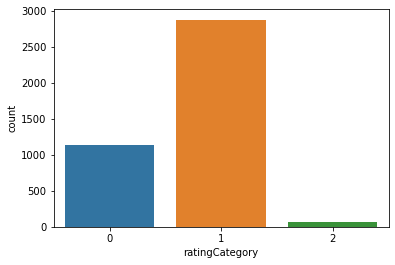

In [5]:
from seaborn import countplot
countplot(train.ratingCategory);

In [6]:
from sklearn.utils import resample

minority = train[train['ratingCategory'] == 0]
majority = train[train['ratingCategory'] == 1]
df_minority_upsampled = resample(minority,
                                 replace=True,
                                 n_samples=majority.shape[0]
                                )
train_upsampled = pd.concat([majority, df_minority_upsampled])

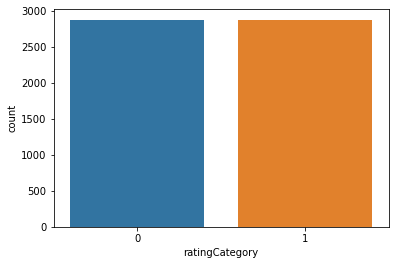

In [7]:
countplot(train_upsampled.ratingCategory);

## tokenization

In [22]:
from spacy.tokenizer import Tokenizer
import en_core_web_lg
nlp = en_core_web_lg.load()
tokenizer = Tokenizer(nlp.vocab)

In [25]:
def tokenize(docs,tokenizer):
    """Takes a tokenizer by defualt i used spacy and adds a list of tokens to the passed df.
    Arguments:
    ---------
    `df` {pd.Dataframe} - the dataframe that is being passed.

    `col_name` {str} - the name of the column that hold the text data.

    `tokenizer` {spacy.tokenizer.Tokenizer} - the tokenizer that breaks the text data into tokens.
    Returns:
    -----------
    `df_cpy` {pd.DataFrame} - a copy of the passed datafram with an added column 'tokens' which holds the tokens from the passed dataframs text data. 
    """
    df_cpy = docs.copy()
    tokens = []

    for doc in tokenizer.pipe(df_cpy['description'],
                              batch_size=500):
        doc_tokens = []
        for token in doc:
            if (token.is_stop == False) & (token.is_punct == False):
                doc_tokens.append(token.text.lower())
        tokens.append(doc_tokens)
    df_cpy['tokens'] = tokens
    return df_cpy

In [26]:
train = tokenize(train,tokenizer)
test = tokenize(test,tokenizer)


## Gensim LDA Topic Modeling

In [28]:
import gensim
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore

In [29]:
id2word = corpora.Dictionary(train.tokens)

In [30]:
id2word.filter_extremes(no_below=5, no_above=0.95)

In [31]:
corpus = [id2word.doc2bow(text) for text in train.tokens]

In [32]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 15,
                   passes=10,
                   workers=8
                  )

In [33]:
lda.print_topics()

[(0,
  '0.015*"sweet" + 0.011*"vanilla" + 0.011*"whisky" + 0.008*"oak" + 0.007*"old" + 0.007*"year" + 0.007*"notes" + 0.006*"it’s" + 0.006*"nose" + 0.006*"finish."'),
 (1,
  '0.014*"chocolate," + 0.011*"palate" + 0.010*"finish" + 0.010*"oak" + 0.009*"dark" + 0.008*"dried" + 0.007*"oak," + 0.007*"orange" + 0.007*"nose" + 0.007*"finish."'),
 (2,
  '0.015*"sweet" + 0.011*"nose" + 0.008*"finish" + 0.007*"whisky" + 0.007*"bit" + 0.006*"it’s" + 0.006*"orange" + 0.006*"flavors" + 0.006*"vanilla," + 0.006*"finish."'),
 (3,
  '0.015*"sweet" + 0.011*"orange" + 0.009*"vanilla," + 0.009*"citrus" + 0.008*"notes" + 0.007*"finish." + 0.007*"nose" + 0.007*"whisky" + 0.007*"spices" + 0.006*"fresh"'),
 (4,
  '0.012*"palate," + 0.010*"nose," + 0.010*"matured" + 0.009*"peat" + 0.009*"finish" + 0.009*"oak" + 0.009*"sweet" + 0.008*"hint" + 0.008*"vanilla," + 0.008*"soft"'),
 (5,
  '0.021*"it\'s" + 0.019*"whisky" + 0.011*"it’s" + 0.010*"malt" + 0.008*"grain" + 0.007*"like" + 0.007*"soft" + 0.006*"good" + 0.0

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [ ]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

## SpaCy vectorization

In [23]:
def get_word_vectors(docs):
    return [nlp(doc).vector for doc in docs]

In [19]:
X_train = get_word_vectors(train['description'])
y_train = train.ratingCategory
X_test = get_word_vectors(test['description'])

## LSI /tfidf

In [114]:
X_train = train['description']
y_train = train.ratingCategory
X_test = test['description']

In [115]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, # Just here for demo. 
                   algorithm='randomized',
                   n_iter=10)

In [116]:
vect = TfidfVectorizer(stop_words='english',ngram_range=[1,3],min_df=5,max_df=0.97)
rfc = RandomForestClassifier()

## Pipeline /randomizedcvsearch

In [117]:
# tfidf -> svd (LSI PIPELINE)
lsi = Pipeline([('vect', vect), ('svd', svd)])

# lsi/xgbooster Pipe
#pipe = Pipeline([('svd',svd), ('clf', rfc)])
pipe = Pipeline([('lsi',lsi), ('clf', rfc)])

In [118]:
params = { 
    'lsi__svd__n_components': [50,100,150,200],
    'lsi__svd__n_iter': [5,10,15,20],
    'clf__n_estimators':[10,20,25,35],
    'clf__max_depth': [5,10,15,25,35]
}

In [119]:
rand_search = RandomizedSearchCV(pipe,param_distributions=params,cv=20,verbose=1,n_jobs=-1)
rand_search.fit(X_train,y_train)

Fitting 20 folds for each of 10 candidates, totalling 200 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.8min finished


RandomizedSearchCV(cv=20, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('lsi',
                                              Pipeline(memory=None,
                                                       steps=[('vect',
                                                               TfidfVectorizer(analyzer='word',
                                                                               binary=False,
                                                                               decode_error='strict',
                                                                               dtype=<class 'numpy.float64'>,
                                                                               encoding='utf-8',
                                                                               input='content',
                                                                               lowercase=True,
                         

## best model/pipe

In [120]:
rand_search.best_estimator_

Pipeline(memory=None,
         steps=[('lsi',
                 Pipeline(memory=None,
                          steps=[('vect',
                                  TfidfVectorizer(analyzer='word', binary=False,
                                                  decode_error='strict',
                                                  dtype=<class 'numpy.float64'>,
                                                  encoding='utf-8',
                                                  input='content',
                                                  lowercase=True, max_df=0.97,
                                                  max_features=None, min_df=5,
                                                  ngram_range=[1, 3], norm='l2',
                                                  preprocessor=None,
                                                  smooth_idf=True,
                                                  stop_words='english',
                                                  strip_

In [121]:
rand_search.best_params_

{'lsi__svd__n_iter': 20,
 'lsi__svd__n_components': 50,
 'clf__n_estimators': 20,
 'clf__max_depth': 15}

In [122]:
rand_search.best_score_

0.7279268292682926

## Predictions/submissions

In [123]:
pred = rand_search.predict(X_test)

In [124]:
sub = pd.DataFrame(columns=['id','ratingCategory'])
sub['id']=test.id
sub['ratingCategory']=pred
sub.to_csv("submission9.csv",index=False)

# Post Lecture Assignment
<a id="p4"></a>

Your primary assignment this afternoon is to achieve a minimum of 70% accuracy on the Kaggle competition. Once you have achieved 70% accuracy, please work on the following: 

1. Research "Sentiment Analysis". Provide answers in markdown to the following questions: 
    - What is "Sentiment Analysis"? 
    - Is Document Classification different than "Sentiment Analysis"? Provide evidence for your response
    - How do create labeled sentiment data? Are those labels really sentiment?
    - What are common applications of sentiment analysis?
2. Research our why word embeddings worked better for the lecture notebook than on the whiskey competition.
    - This [text classification documentation](https://developers.google.com/machine-learning/guides/text-classification/step-2-5) from Google might be of interest
    - Neural Networks are becoming more popular for document classification. Why is that the case?

# OLD

In [34]:
# first
pipe = Pipeline(
    [
        ('vect',vect),
        ('clf',rfc)
    ]
)
parameters = {
    "vect__max_df" : (0.75,1.00),
    "vect__min_df" : (.02,.05),
    "clf__n_estimators":(5,10,),
    "clf__max_depth":(15,20)
}
rand_search = RandomizedSearchCV(pipe,param_distributions=parameters,cv=5,verbose=1,n_jobs=-1)
rand_search.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   40.9s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=0.97,
                                                              max_features=None,
                                                              min_df=5,
                                                       